# Variables globales

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import gaussian_kde
import networkx as nx
import os
import pickle

In [33]:
m_e = 9.10938356e-31 #en kg
hbar = 1.0545718e-34 #en J.s
e = 1.602176634e-19 #en C
phi = 2*e #en eV
kB = 1.380649e-23 #en J/K
T = 300 #en K

In [34]:
N = 30 # Taille de la grille
a = 1e-9 # Taille de chaque maille élémentaire
sigma = 0.3 #Ecart-type du bruit gaussien
n_el_initial = 100
# Précision de la tension : environ 34 décimales
N_iterations = 500 # Nombre d'itérations par étape
prob_deb = 0.2 # Probabilité de rester dans le début de la grille à chaque initialisation
dropout = 0 # Probabilité de disparition des sites
coupe = 0.5 #Permet de cadrer la possibilité pour un électron de sortir de sa case, 0.5 pour rester dans sa case
sigma_elec = 1.42
mode = "normal" # "normal" ou "uniform"
# "normal" : distribution normale centrée sur 0, "uniform" : distribution uniforme entre 0 et 1

In [35]:
li_va_globales = ['N','a','sigma','n_el_initial','N_iterations','prob_deb','dropout','coupe','sigma_elec']

# Initialisation

In [36]:
z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
x = np.random.normal(0,sigma/2,size = (N,N))
y = np.random.normal(0,sigma/2,size = (N,N))
x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
y = np.clip(y,-coupe,coupe) #Idem
bruit = np.stack((x,y),axis=-1) 
z += bruit #Génère le bruit gaussien

electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
if dropout < 1e-11:
    dropout = 0.
    sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests

proj  = np.zeros(N,dtype = float)
for i in range(N):
    if sites[i,0]==1:
        proj[i] = abs(y[i,0])
s = np.sum(proj)
if s > 0:
    proj /= s

In [37]:
def reinitialise():
    """Permet de réinitialiser les paramètres entre deux modélisations"""
    global x,y,z,electrons,bruit,traces, sites, proj
    z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
    x = np.random.normal(0,sigma/2,size = (N,N))
    y = np.random.normal(0,sigma/2,size = (N,N))
    x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
    y = np.clip(y,-coupe,coupe) #Idem
    bruit = np.stack((x,y),axis=-1) 
    z += bruit #Génère le bruit gaussien

    electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
    traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
    sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
    if dropout < 1e-11:
        sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests
    
    proj  = np.zeros(N,dtype = float)
    for i in range(N):
        if sites[i,0]==1:
            proj[i] = 1/abs(y[i,0])
    s = np.sum(proj)
    if s > 0:
        proj /= s

# Affichage

## Représentation en grille

In [38]:
def affiche_grille(z):
    N,_,_ = z.shape
    plt.xticks(np.arange(0,N,1), labels = [])
    plt.yticks(np.arange(0,N,1), labels = [])
    for i in range(N):
        for j in range(N):
            if sites[i,j]==1:
                xc = i+0.5 + z[i,j,0]
                yc = j+0.5 + z[i,j,1]
                plt.scatter(xc,yc, color = "red")
    plt.grid()

In [39]:
def affiche_electrons(electrons):
    fig, ax = plt.subplots()
    N,_ = electrons.shape
    plt.xticks(np.arange(0,N+1,1), labels = [])
    plt.yticks(np.arange(0,N+1,1), labels = [])
    for i in range(N):
        for j in range(N):
            if electrons[i,j]>0:
                rect = patches.Rectangle((i, j), 1, 1, color='black', alpha=0.5) 
                ax.add_patch(rect)           
    plt.grid()

In [40]:
def heatmap(electrons, dossier="",titre = "Carte des électrons"):
    """Affiche la carte de chaleur des électrons sur la grille"""
    plt.figure(figsize=(10, 10))
    plt.xticks(ticks=np.arange(electrons.shape[1]), labels=np.arange(electrons.shape[1]))
    plt.yticks(ticks=np.arange(electrons.shape[0]), labels=np.arange(electrons.shape[0]))

    # Tracer la heatmap
    plt.imshow(electrons, cmap=plt.cm.Blues, vmin=1)  # vmin=1 pour que les valeurs 0 soient blanches
    plt.colorbar()  # Ajouter une barre de couleur
    plt.title(titre)
    if dossier != "":
        chemin = os.path.join(dossier,titre+".png")
        plt.savefig(chemin)
    plt.show()

## Représentation en graphe

In [41]:
def affiche_graphes_colormap(probabilites, chemins, head=5, titre="Graphe des électrons", dossier=""):
    global electrons, sites, N, x, y
    G = nx.DiGraph()

    for case, voisines in probabilites.items():
        for voisine, prob in voisines.items():
            G.add_edge(case, voisine, weight=prob)

    # Positionner les nœuds dans une grille
    pos = {(i, j): (j + x[j, i], N - i - y[j, i]) for i in range(N) for j in range(N)}

    fig, ax = plt.subplots(figsize=(30, 30))  # Ajustez la taille de la figure ici

    cmap_nodes = plt.get_cmap('coolwarm')

    # Dessiner les nœuds avec une taille réduite et une colormap basée sur electrons
    node_values = [electrons[node[0], node[1]] for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=False, node_size=100, node_color=node_values,
        cmap=cmap_nodes, ax=ax, arrows=False, edgelist=[]
    )

    # Dessiner les arêtes avec des couleurs basées sur les poids
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = max(weights) if weights else 1
    cmap_edges = plt.get_cmap('coolwarm')

    # Dessiner les arêtes avec des flèches
    nx.draw_networkx_edges(
        G, pos, edge_color=weights, edge_cmap=cmap_edges, edge_vmin=0, edge_vmax=max_weight,
        connectionstyle="arc3,rad=0.3", arrows=True, ax=ax
    )

    # Dessiner les chemins avec des couleurs différentes
    if len(chemins) > 0:
        chemin_colors = plt.cm.tab10(np.linspace(0, 1, head))  # Utiliser une colormap pour les chemins
        indices = np.random.choice(np.arange(len(chemins)), size=head, replace=False) if len(chemins) > head else np.arange(len(chemins))
        for (i, idx) in enumerate(indices):
            chemin = chemins[idx]
            chemin_positions = [pos[node] for node in chemin]
            chemin_x, chemin_y = zip(*chemin_positions)
            ax.plot(chemin_x, chemin_y, color=chemin_colors[i], linewidth=3, alpha=0.7, label=f"Chemin {i+1}")

    # Ajouter une barre de couleur pour les nœuds
    sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(0, max(node_values)))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, ax=ax, label='Valeur des électrons')

    # Ajouter une barre de couleur pour les arêtes
    sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(0, max_weight))
    sm_edges.set_array([])
    cbar_edges = plt.colorbar(sm_edges, ax=ax, label='Probabilité')

    # Ajouter les barres noires à droite et à gauche

    # Ajouter les axes
    #ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    #ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.annotate('', xy=(N+1, 0), xytext=(-1, 0),
             arrowprops=dict(arrowstyle='->', color='grey', lw=2.5))
    plt.annotate('', xy=(-1, N+1), xytext=(-1, 0),
             arrowprops=dict(arrowstyle='->', color='grey', lw=2.5))
    
    ax.plot([-1, -1], [0, N], color='black', linewidth=3)
    ax.plot([N, N], [0, N], color='black', linewidth=3)


    # Afficher le graphe
    plt.title(titre)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(np.arange(0, N, 1))
    plt.yticks(np.arange(0, N, 1))
    plt.legend(loc='upper right')
    if dossier != "":
        chemin = os.path.join(dossier, titre + ".png")
        plt.savefig(chemin)
    plt.show()


In [42]:
def affiche_graphe(probabilites, head=5, titre="Schéma du memristor", dossier=""):
    global electrons, sites, N, x, y
    G = nx.DiGraph()

    for case, voisines in probabilites.items():
        for voisine, prob in voisines.items():
            G.add_edge(case, voisine, weight=prob)

    # Positionner les nœuds dans une grille
    pos = {(i, j): (j + x[j, i], N - i - y[j, i]) for i in range(N) for j in range(N)}

    fig, ax = plt.subplots(figsize=(30, 30))  # Ajustez la taille de la figure ici

    cmap_nodes = plt.get_cmap('coolwarm')

    # Dessiner les nœuds avec une taille réduite et une colormap basée sur electrons
    #node_values = [electrons[node[0], node[1]] for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=False, node_size=100, ax=ax, arrows=False, edgelist=[]
    )

    # Dessiner les arêtes avec des couleurs basées sur les poids
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = max(weights) if weights else 1
    cmap_edges = plt.get_cmap('coolwarm')

    # Dessiner les arêtes avec des flèches
    nx.draw_networkx_edges(
        G, pos, edge_color=weights, edge_cmap=cmap_edges, edge_vmin=0, edge_vmax=max_weight,
        connectionstyle="arc3,rad=0.3", arrows=True, ax=ax
    )

    # Ajouter une barre de couleur pour les arêtes
    sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(0, max_weight))
    sm_edges.set_array([])
    cbar_edges = plt.colorbar(sm_edges, ax=ax, label='Probabilité')

    # Ajouter les barres noires à droite et à gauche

    ax.plot([-1, -1], [0, N], color='black', linewidth=3, label = "Electrode")
    ax.plot([N, N], [0, N], color='black', linewidth=3)


    # Afficher le graphe
    plt.title(titre)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(np.arange(0, N, 1))
    plt.yticks(np.arange(0, N, 1))
    plt.legend(loc='upper right')
    if dossier != "":
        chemin = os.path.join(dossier, titre + ".png")
        plt.savefig(chemin)
    plt.show()


In [43]:
from random import shuffle
def affiche_chemins(chemins, head=5, titre="Graphe des chemins", dossier=""):
    global electrons, sites, N, x, y
    G = nx.DiGraph()

    for i in range(N):
        for j in range(N):
            if sites[i,j]==1:
                G.add_node((i,j), weight=electrons[i,j])

    # Positionner les nœuds dans une grille
    pos = {(i, j): (j + x[j, i], N - i - y[j, i]) for i in range(N) for j in range(N)}

    fig, ax = plt.subplots(figsize=(30, 30))  # Ajustez la taille de la figure ici

    nx.draw(
        G, pos, with_labels=False, node_size=100, ax=ax, arrows=False, edgelist=[]
    )


    if len(chemins) > 0:
        chems = [(chemin,len(chemin)) for chemin in chemins if len(chemin) > 4]
        #shuffle(chems)
        chems.sort(key = lambda x : x[1], reverse = True)
        chems_select = [chems[i][0] for i in range(min(head,len(chems)))]
        chemin_colors = plt.cm.tab10(np.linspace(0, 1, head))  # Utiliser une colormap pour les chemins
        for (i, chemin) in enumerate(chems_select):
            chemin_positions = [pos[node] for node in chemin]
            chemin_x, chemin_y = zip(*chemin_positions)
            chemin_x = list(chemin_x)
            chemin_y = list(chemin_y)
            if len(chemin_x) > 0:
                chemin_x.insert(0,-1)
                chemin_x.append(N)
                chemin_y.insert(0,chemin_y[0])
                chemin_y.append(chemin_y[-1])
            ax.plot(chemin_x, chemin_y, color=chemin_colors[i], linewidth=5, alpha=0.7, label=f"Chemin {i+1}")

    # Ajouter les barres noires à droite et à gauche
    ax.plot([-1, -1], [0, N], color='black', linewidth=3, label = "Electrode")
    ax.plot([N, N], [0, N], color='black', linewidth=3)

    # Afficher le graphe
    plt.title(titre)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(np.arange(0, N, 1))
    plt.yticks(np.arange(0, N, 1))
    plt.legend(loc='upper right')
    if dossier != "":
        chemin = os.path.join(dossier, titre + ".png")
        plt.savefig(chemin)
    plt.show()


In [44]:
def print_distrib(chem, titre="Distribution des chemins", dense = False, dossier = ""):
    """Affiche la distribution des chemins des électrons avec densité"""
    chemin_lengths = [len(chem[i]) for i in range(len(chem))]
    if len(chemin_lengths)>1:
        dense = False
    if len(chem)>0:
        xs = np.linspace(min(chemin_lengths), max(chemin_lengths), 200)
    else:
        xs = np.linspace(0, 1, 10)
    # Tracer l'histogramme et la densité
    plt.figure(figsize=(10, 5))
    if dense:
        plt.plot(xs, gaussian_kde(chemin_lengths)(xs), color='red', label="Densité")
    else:
        plt.hist(chemin_lengths, bins='auto', color='blue', alpha=0.7, density=dense, label=f"Nombre de chemins : {len(chemin_lengths)}")
    plt.title(titre)
    plt.xlabel('Longueur du chemin')
    if dense:
        density = gaussian_kde(chemin_lengths)
        density_values = density(xs)
        plt.plot(xs, density_values, color='red', label="Densité")
        plt.ylabel("Densité")
    else:
        plt.ylabel("Nombre d'électrons")
    plt.grid()
    plt.legend()
    if dossier != "":
        chemin = os.path.join(dossier,titre+".png")
        plt.savefig(chemin)
    plt.show()

# Initialisation

In [45]:
def first_initialisation():
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors de la première passe"""
    pos = np.random.choice(np.arange(N), size = n_el_initial, p = proj)
    for electron in range(n_el_initial):
        position = pos[electron]
        electrons[position,0] += 1
        traces[electron] = [(position,0)]

In [46]:
def initialise(chemins):
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors des passes suivantes. 
    Utilise la liste des chemins existants."""
    for elec in range(n_el_initial):
        t = np.random.choice(["Début", "Fin"], p = [prob_deb, 1 - prob_deb])
        if len(chemins)==0 or t=="Début":
            position = np.random.choice(np.arange(N), p = proj)
            electrons[position,0] += 1
            traces[elec] = [(position,0)]
        else:
            chem = np.random.choice(np.arange(len(chemins)))
            pos_chem = np.random.choice(np.arange(len(chemins[chem])))
            position = chemins[chem][pos_chem]
            electrons[position] += 1
            traces[elec] = chemins[chem][:pos_chem+1]

# Probabilités de déplacement

In [47]:
def position_into_reality(i,j):
    return a*(i+z[i,j,0]),a*(j+z[i,j,1])

In [48]:
def distance(i,j,k,l):
    xi,yi = position_into_reality(i,j)
    xj,yj = position_into_reality(k,l)
    return np.sqrt((xi-xj)**2 + (yi-yj)**2)

In [49]:
def tension(V,i,j):
    """Calcule le potentiel en un point de la grille"""
    return (1-(i/N))*V

In [ ]:
# def prob(V,i,j,k,l):
#     """Renvoie la probabilité de passer d'une case à une autre"""
#     global sigma_elec
#     Delta = distance(i,j,k,l)
#     V_i = e*tension(V,i,j)
#     V_f = e*tension(V,k,l)
#     V = max(V_i,V_f) + phi
#     if mode=="uniform":
#         E = np.random.random()*(V-V_i) + V_i
#     else:
#         E = np.tanh(np.random.normal(0,sigma_elec))*(V-V_i)/2 + ((V+V_i)/2)
#     if E<V_f:
#         return 0.
#     else:
#         k = np.sqrt(2*m_e*(E-V_i))/hbar
#         K = np.sqrt(2*m_e*(V-E))/hbar
#         kappa = np.sqrt(2*m_e*(E-V_f))/hbar
#         t = 4*np.exp(-kappa*Delta*1j) * (2*(1+kappa/k)*np.cosh(K*Delta) -2*(1j*kappa/K + K/(1j*k))*np.sinh(K*Delta))**(-1)
#         return abs(t)**2

def prob(V,i,j,k,l):
    global sigma_elec
    Delta = distance(i,j,k,l)
    V_i = tension(V,i,j)
    V_f = tension(V,k,l)
    k = np.sqrt(2*m_e*phi)/hbar
    return np.exp(-k*Delta)*np.exp(e*(V_i-V_f)/(kB*T))

In [51]:
def calcul_probas2(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = prob(V,i,j,i,j+1)
        if j>0 and sites[i,j-1] == 1:
            bas = prob(V,i,j,i,j-1)
        if i+1<N and sites[i+1,j] == 1:
            droite = prob(V,i,j,i+1,j)
        if i>0 and sites[i-1,j] == 1:
            gauche = prob(V,i,j,i-1,j)
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.

def calcul_probas(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = 4
        if j>0 and sites[i,j-1] == 1:
            bas = 1
        if i+1<N and sites[i+1,j] == 1:
            droite = 2
        if i>0 and sites[i-1,j] == 1:
            gauche = 2
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.

In [52]:
def pp_probas(V,case):
    droite,gauche,haut,bas = calcul_probas(V,case[0],case[1])
    print(f"Case ({case[0]}, {case[1]}):")
    print(f"\t Probabilité d'aller à droite : {droite}")
    print(f"\t Probabilité d'aller à gauche : {gauche}")
    print(f"\t Probabilité d'aller en haut : {haut}")
    print(f"\t Probabilité d'aller en bas : {bas}")

In [53]:
pp_probas(1, (3,3))

Case (3, 3):
	 Probabilité d'aller à droite : 0.2222222222222222
	 Probabilité d'aller à gauche : 0.2222222222222222
	 Probabilité d'aller en haut : 0.4444444444444444
	 Probabilité d'aller en bas : 0.1111111111111111


In [54]:
def dico_probas(V,seuil=1e-10):
    """Renvoie un dictionnaire contenant les probabilités de chaque case"""
    dico = {}
    for i in range(N):
        for j in range(N):
            dico[(i,j)] = {}
            if sites[i,j]==1:
                droite,gauche,haut,bas = calcul_probas2(V,i,j)
                if droite>seuil:
                    dico[(i,j)][(i+1,j)] = droite
                if gauche>seuil:
                    dico[(i,j)][(i-1,j)] = gauche
                if haut>seuil:
                    dico[(i,j)][(i,j+1)] = haut
                if bas>seuil:
                    dico[(i,j)][(i,j-1)] = bas
    return dico

In [55]:
#dico = dico_probas(5)
#affiche_graphe(dico, titre = "Graphe des probabilités", dossier = "")

# Réalisation d'une transition

In [56]:
def deplacement(V,elec,probs):
    global electrons,traces
    i,j = traces[elec][-1]
    clefs = list(probs[(i,j)].keys())
    if len(clefs) != 0:
        valeurs = list(probs[(i,j)].values())
        indice = np.random.choice(np.arange(len(clefs)), p = valeurs)
        new = clefs[indice]
        traces[elec].append(new)
        electrons[i,j] -= 1
        electrons[new[0],new[1]] += 1

In [57]:
def transition(V, probas):
    for k in range(n_el_initial):
        deplacement(V,k,probas)

# Réalisation de l'étape

In [58]:
def calcule_intensite(V,chem):
    li = np.array([len(chemin) for chemin in chem])
    res = 1/(np.sum(1/li))
    return V/res

In [59]:
def etape(V, chem, first = False):
    global traces, n_el_initial,N_iterations
    if first:
        first_initialisation()
    else:
        initialise(chem)
    for i in range(N_iterations):
        probas = dico_probas(V)
        transition(V,probas)
    liste = [chemin for chemin in traces.values() if chemin[-1][1]==N-1]
    return calcule_intensite(V,liste),liste, probas
    

In [60]:
def plot_deux_couleurs(x_points,y_points,dossier,titre, sep = 10,ylabel= "Intensité (A)"):
    plt.scatter(x_points[:10], y_points[:10], color='red', label='Phase de montée', marker='x')
    plt.scatter(x_points[10:], y_points[10:], color='blue', label='Phase de descente', marker='x')

    plt.legend()
    plt.xlabel('Tension (V)')
    plt.ylabel(ylabel)
    plt.title(titre)
    chemin_fichier = os.path.join(dossier,titre+".png")
    plt.grid()   
    plt.savefig(chemin_fichier)
    plt.show()    

In [61]:
def simulation(array_V, id = "12",affiche = True, trace_carac = True, snapshot = [0,10,20]):
    global dropout, N
    reinitialise()
    chem = []
    intense = []
    nb_chem = []
    moy_chem = []
    var_chem = []
    if not os.path.exists(id):
        os.makedirs(id)
    for (i,V) in enumerate(array_V):
        intensite, chem, probas = etape(V,chem,(i==0))
        chemins = np.array([len(chemin) for chemin in chem])
        moy_chem.append(np.mean(chemins))
        var_chem.append(np.var(chemins))
        nb_chem.append(len(chem))
        intense.append(intensite)
        print(f"Etape {i}, Intensité : {intensite}")
        if affiche:
            if i in snapshot:
                affiche_graphe(probas, titre = f"Schéma du memristor à V = {V}, étape {i}", dossier = id)
                affiche_chemins(chem, titre = f"Chemins des électrons à V = {V}, étape {i}", dossier = id)
                affiche_graphes_colormap(probas, [chemin for chemin in chem if len(chemin)>4], titre = f"Schéma complet du memristor à V = {V}, étape {i}", dossier = id)
            heatmap(electrons, titre = f"Position des électrons à V = {V}, étape {i}", dossier = id)
            print_distrib(chem, titre = f"Distribution des chemins à V = {V}, étape {i}", dossier = id)
    if trace_carac:
        plot_deux_couleurs(array_V,intense,id,f"Caractéristique I(V)", ylabel = "Intensité (A)")
        plot_deux_couleurs(array_V,nb_chem,id,f"Evolution du nombre de chemins", ylabel = "Nombre de chemins")
        plot_deux_couleurs(array_V,moy_chem,id,f"Evolution de la longueur moyenne des chemins", ylabel = "Longueur moyenne des chemins")
        plot_deux_couleurs(array_V,var_chem,id,f"Evolution de la variance des chemins", ylabel = "Variance des chemins")
            
    variables_globales = globals()
    chemin_fichier = os.path.join(id, "variables_globales.txt")
    with open(chemin_fichier,"w") as f:
        for nom in li_va_globales:
            f.write(f"{nom} : {variables_globales[nom]}\n")
    
    chemin_fichier = os.path.join(id,"intensite.pkl")
    with open(chemin_fichier,"wb") as f:
        pickle.dump(intense,f)
    chemin_fichier = os.path.join(id,"tension.pkl")
    with open(chemin_fichier,"wb") as f:
        pickle.dump(array_V,f)
    chemin_fichier = os.path.join(id,"nb_chem.pkl")
    with open(chemin_fichier,"wb") as f:
        pickle.dump(nb_chem,f)
    return intense

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7240\3073740732.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  res = 1/(np.sum(1/li))
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site

Etape 0, Intensité : 0.0


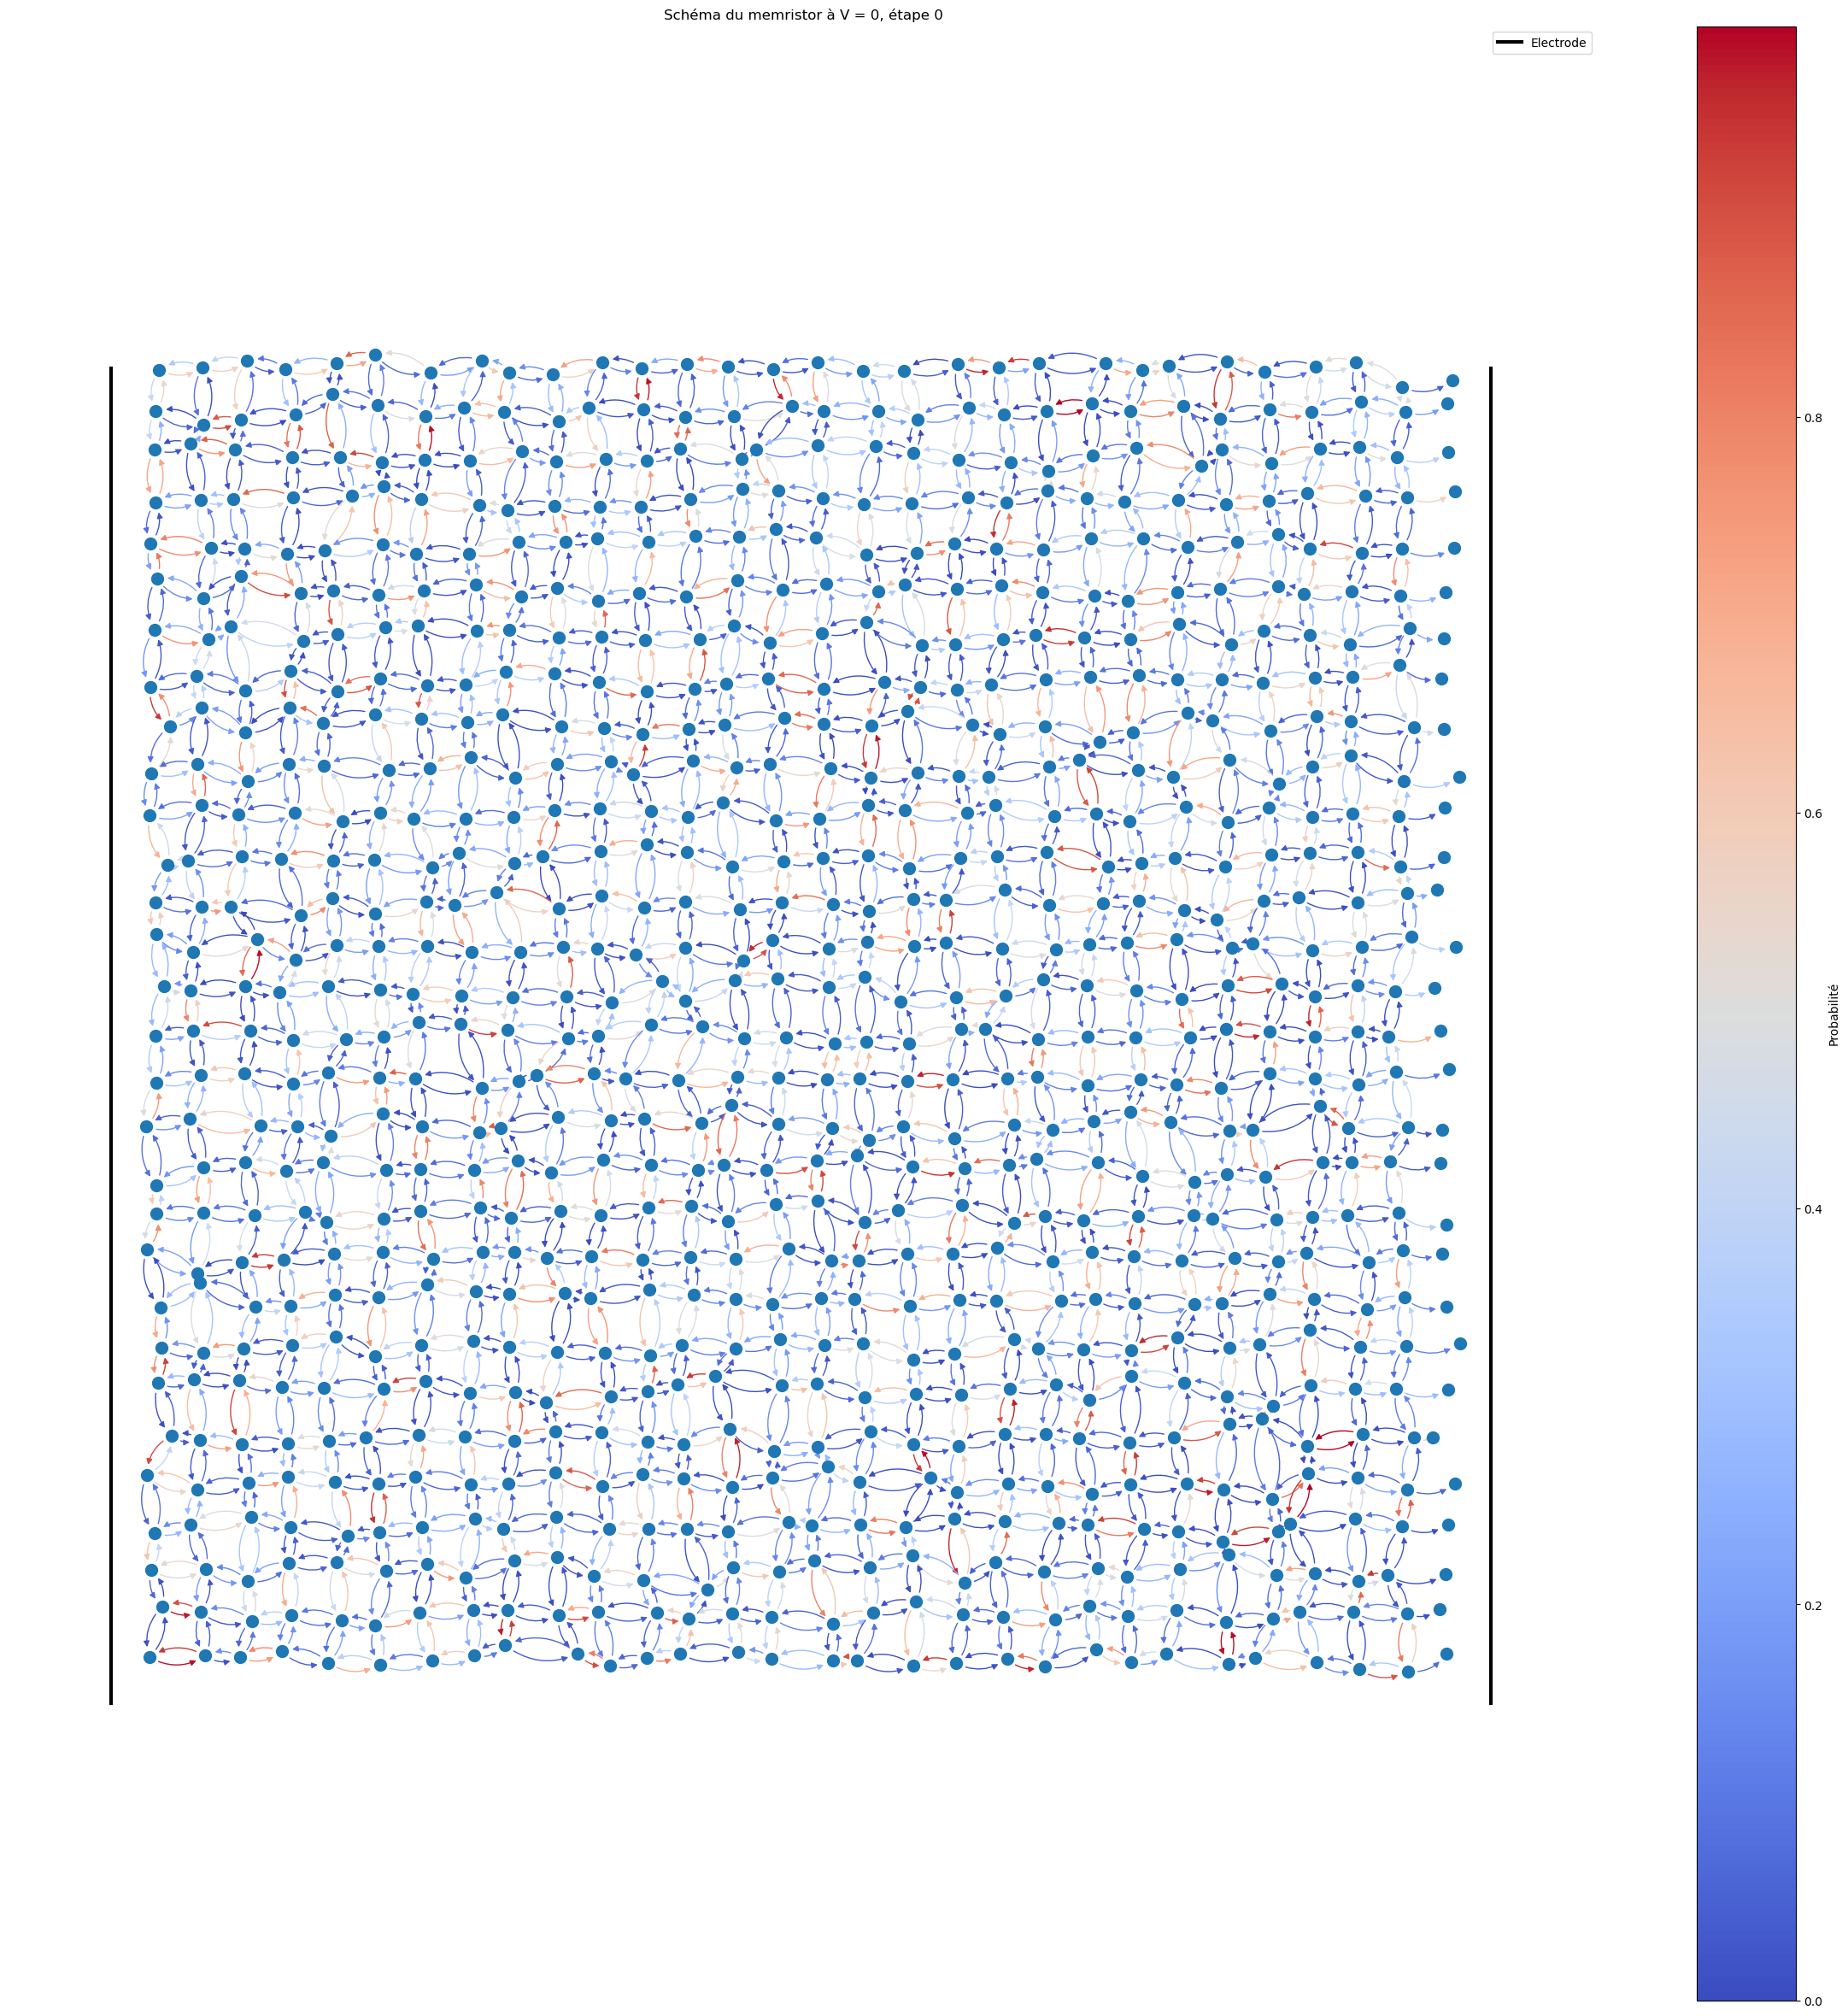

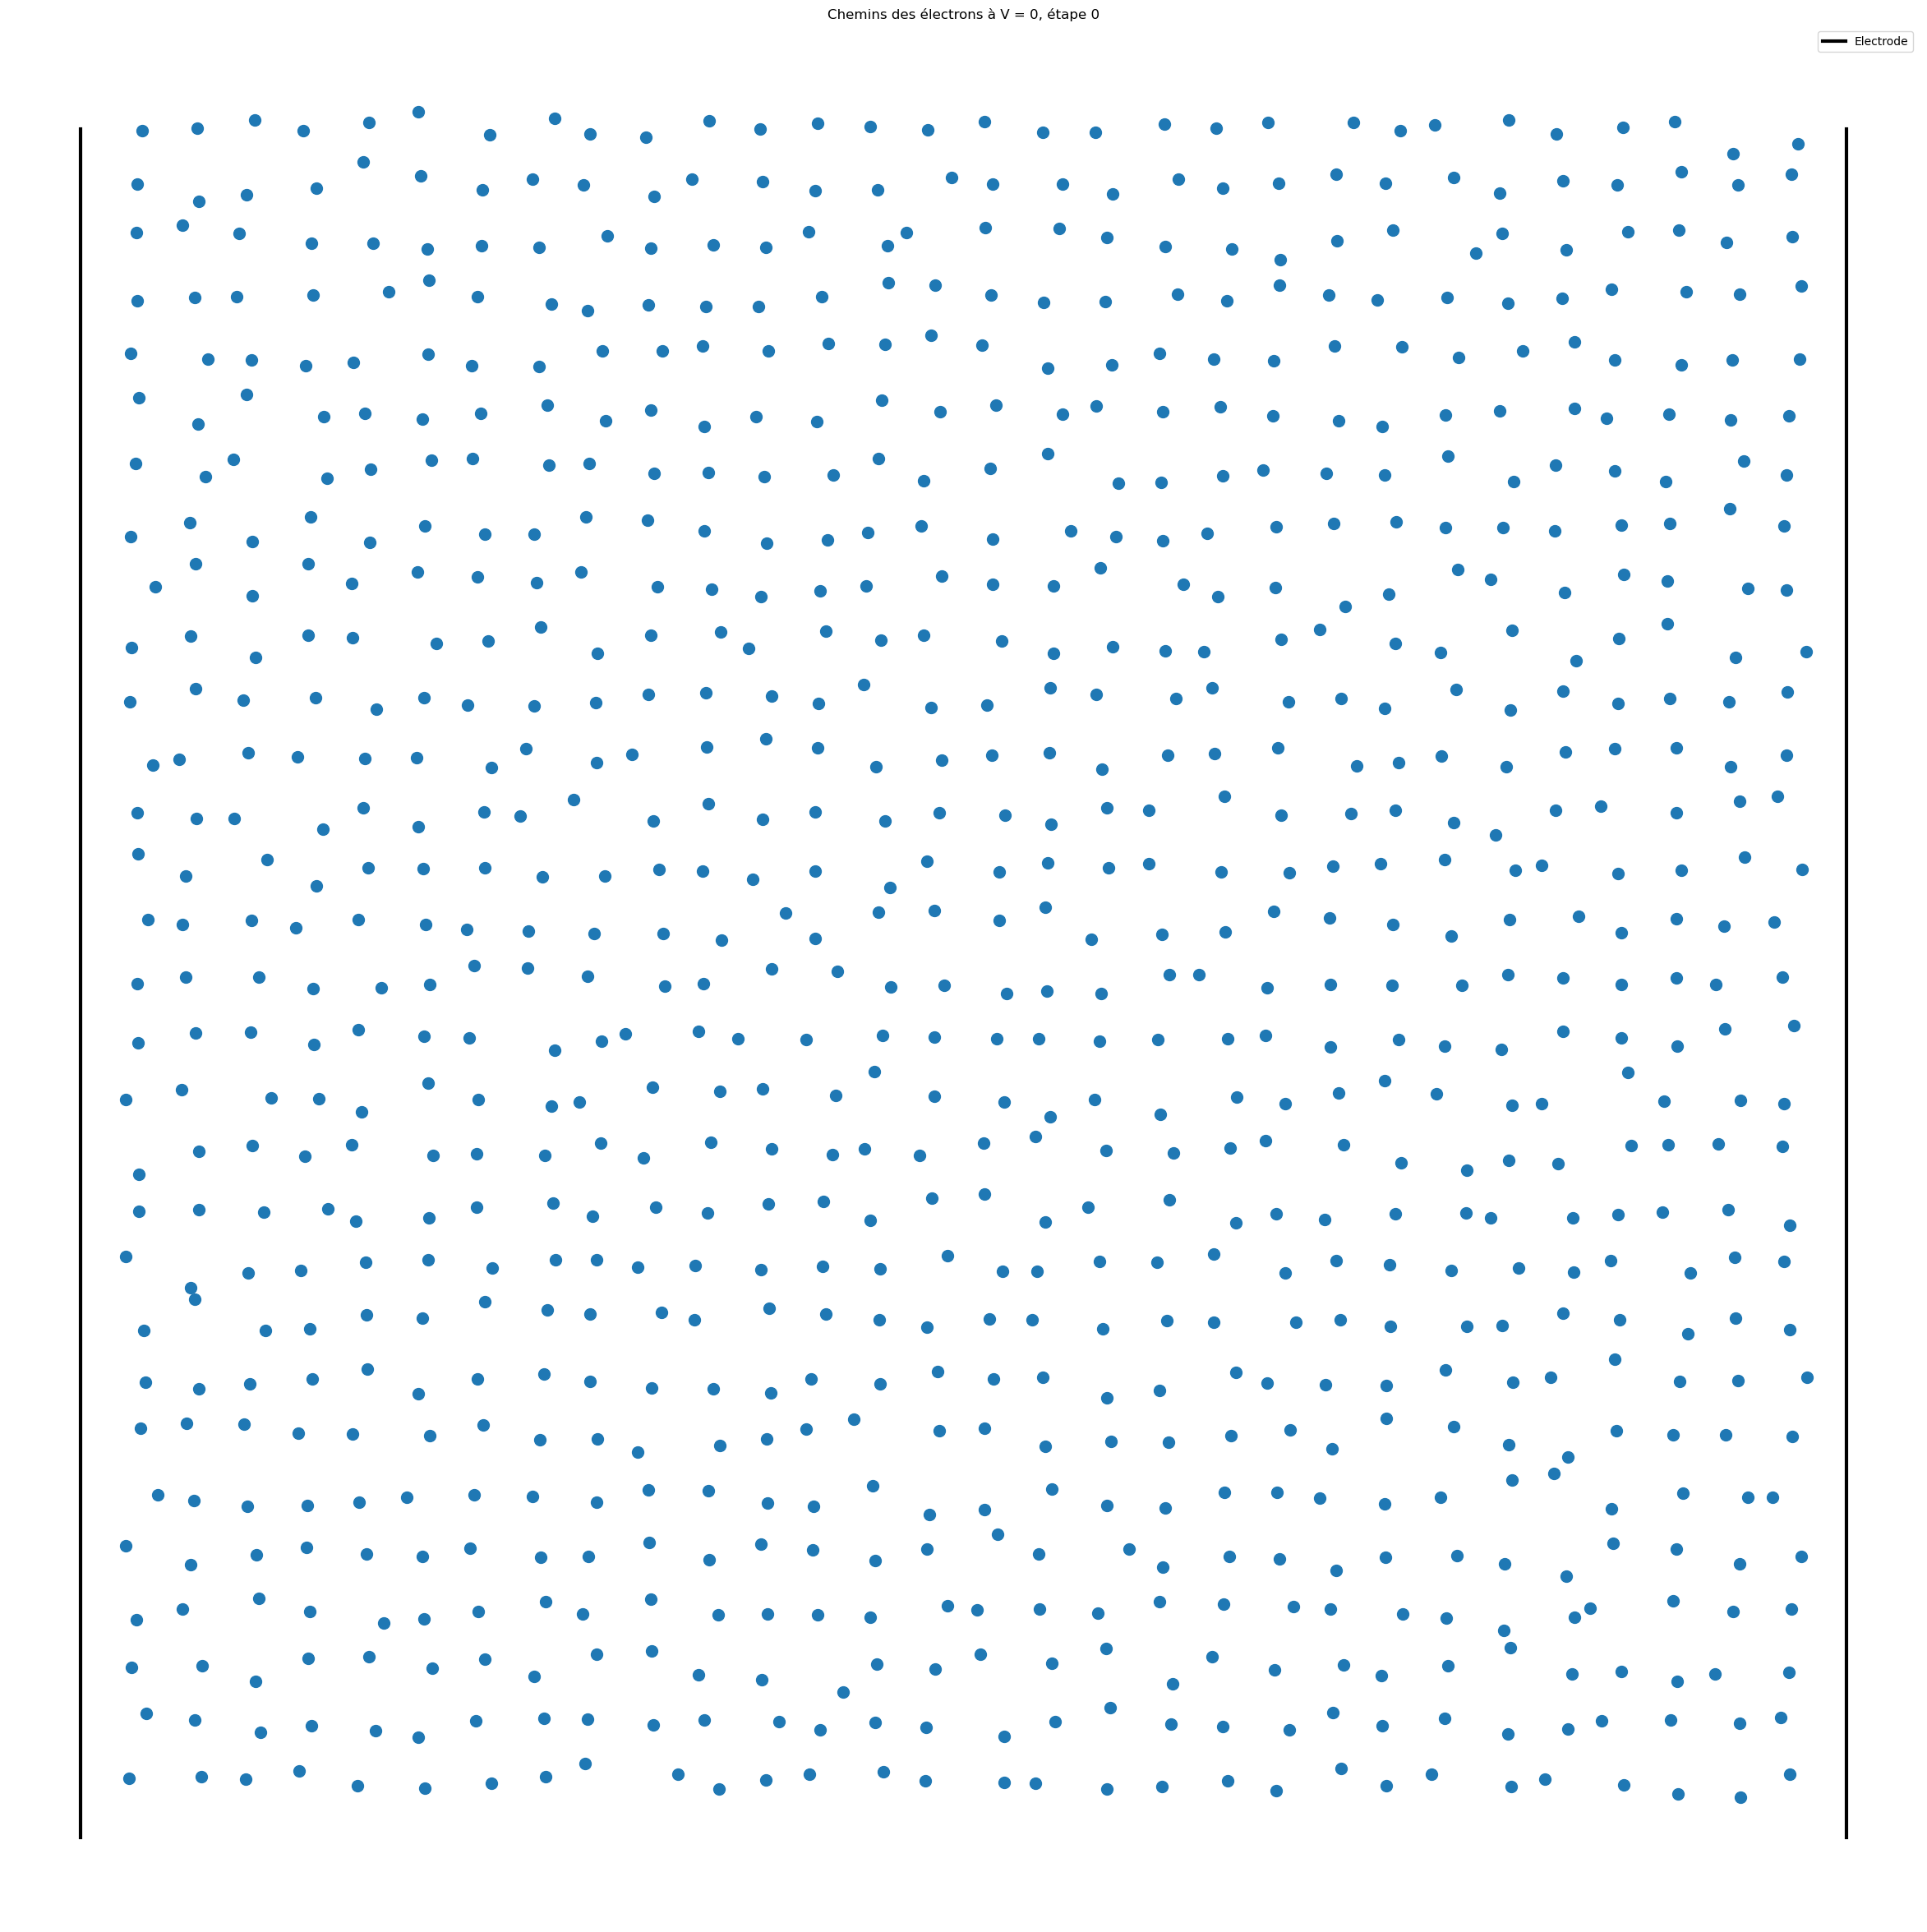

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7240\1841875591.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


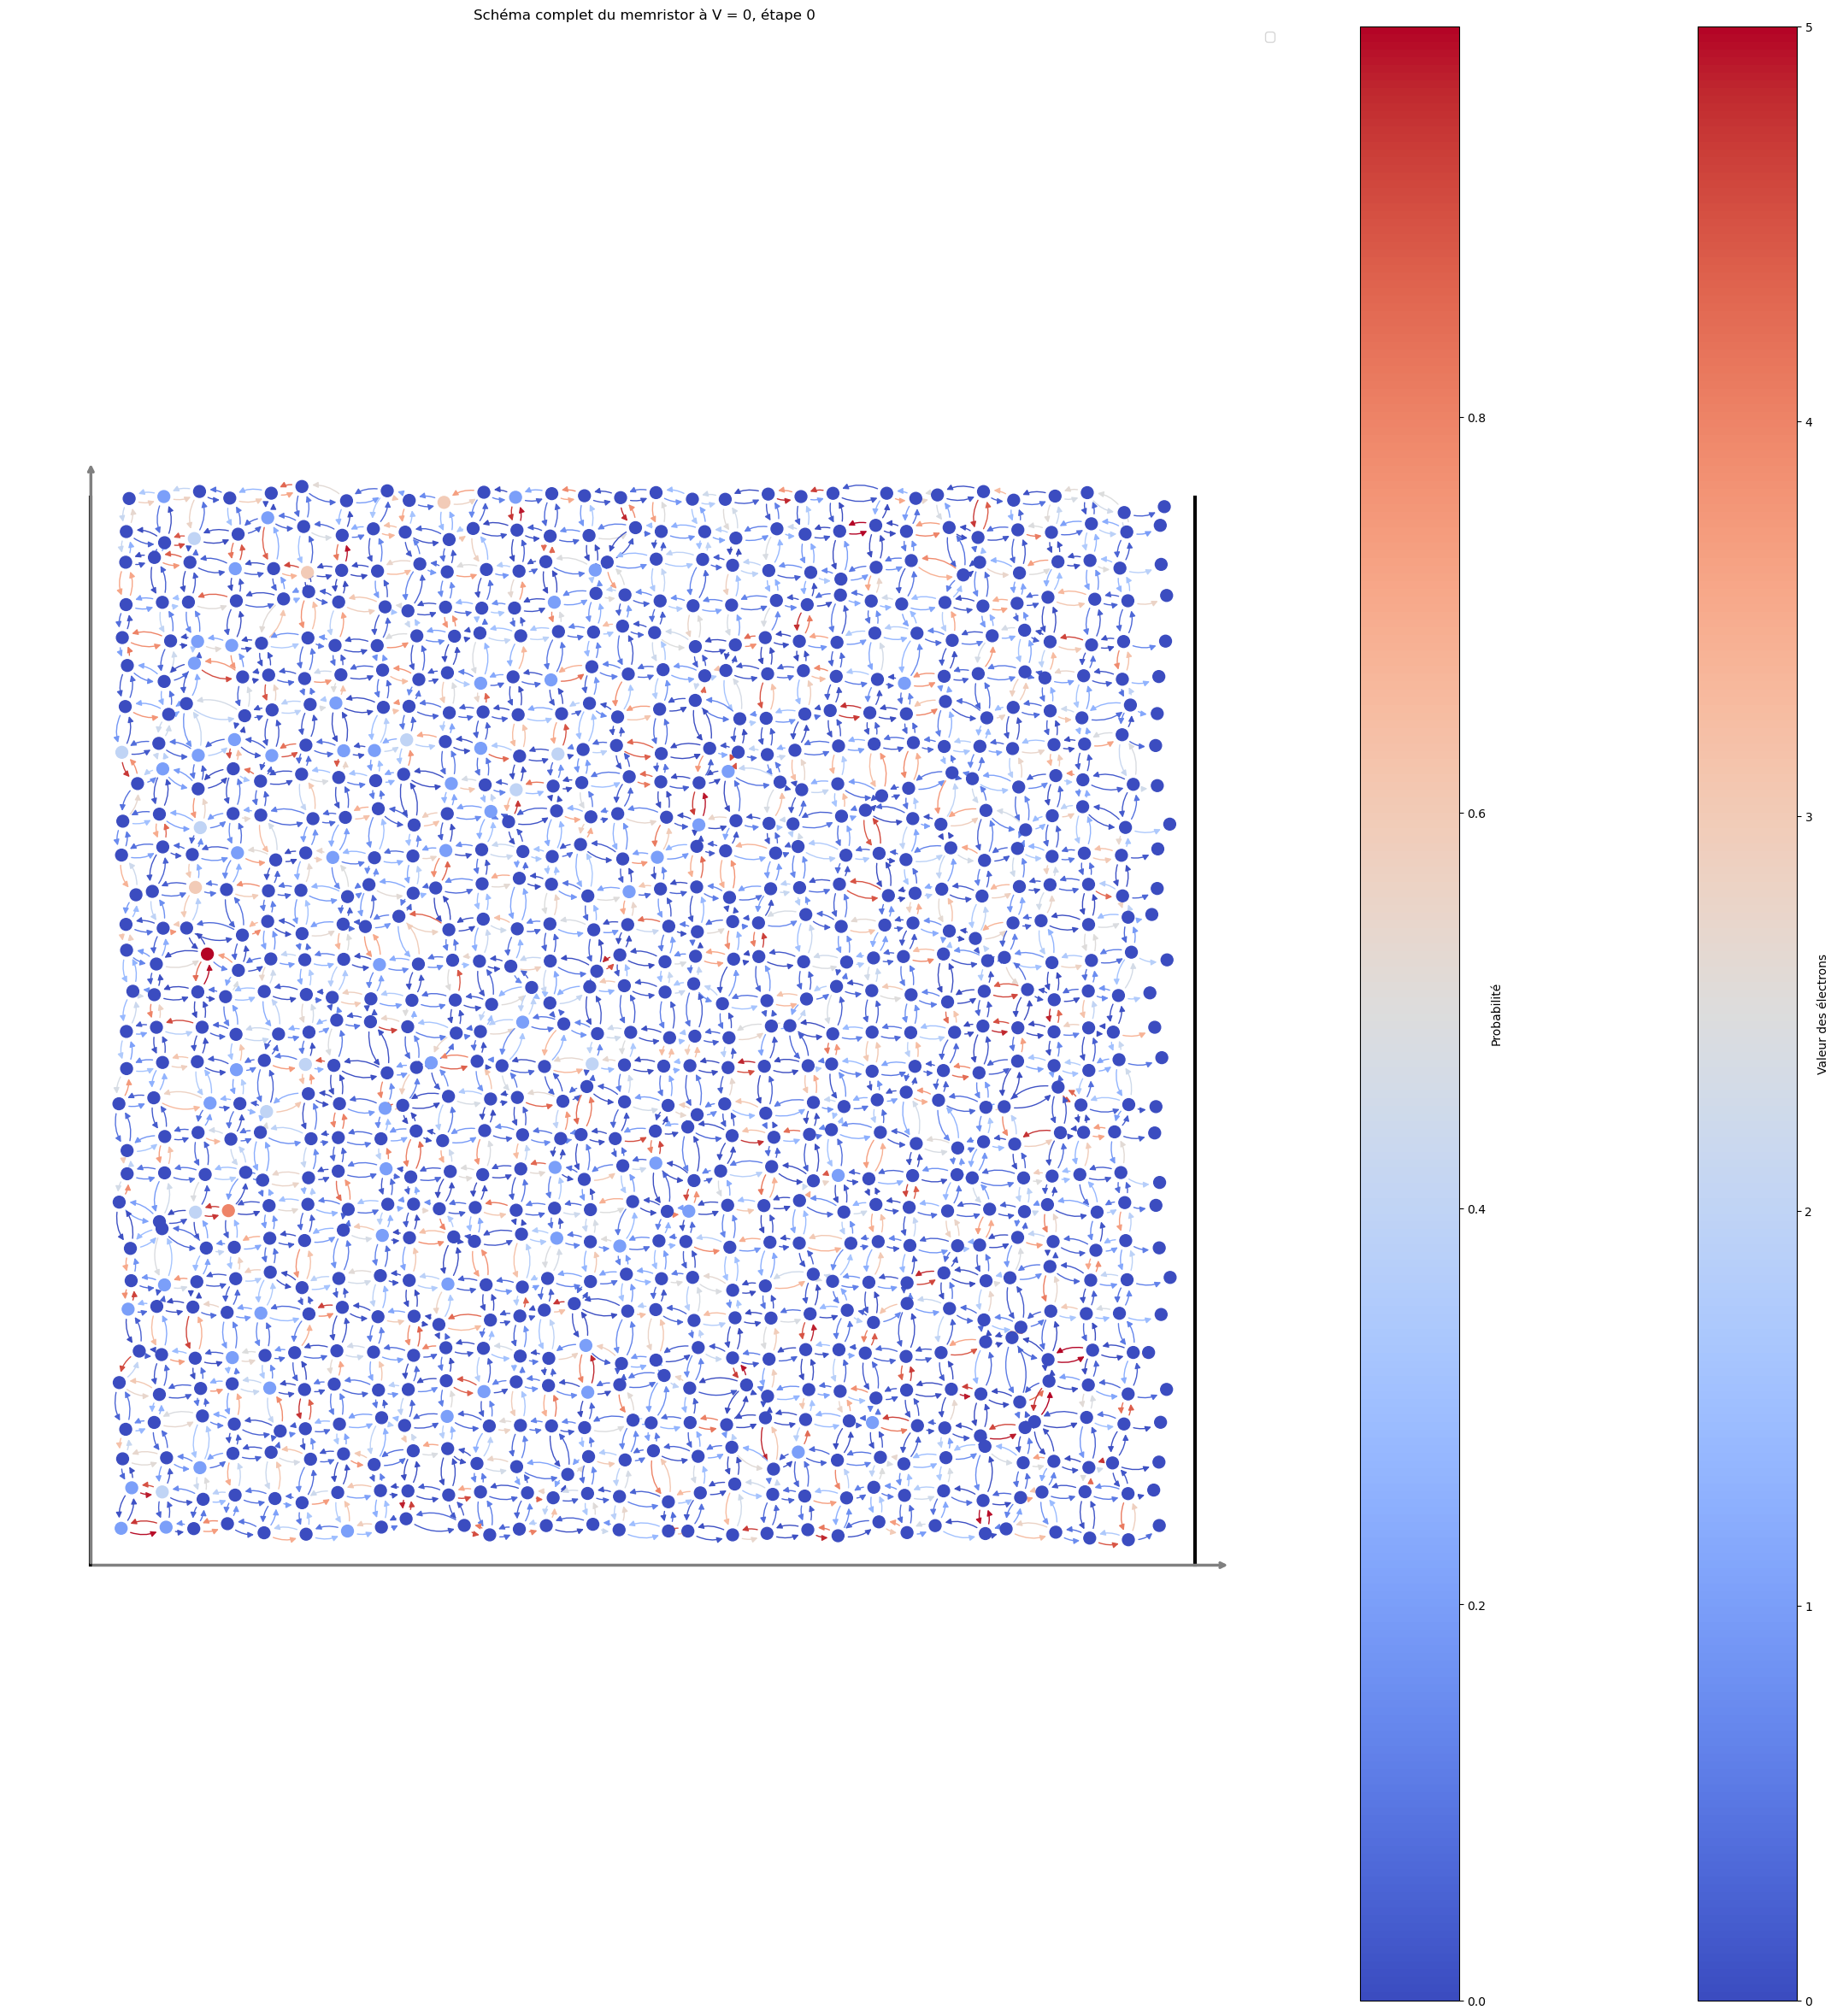

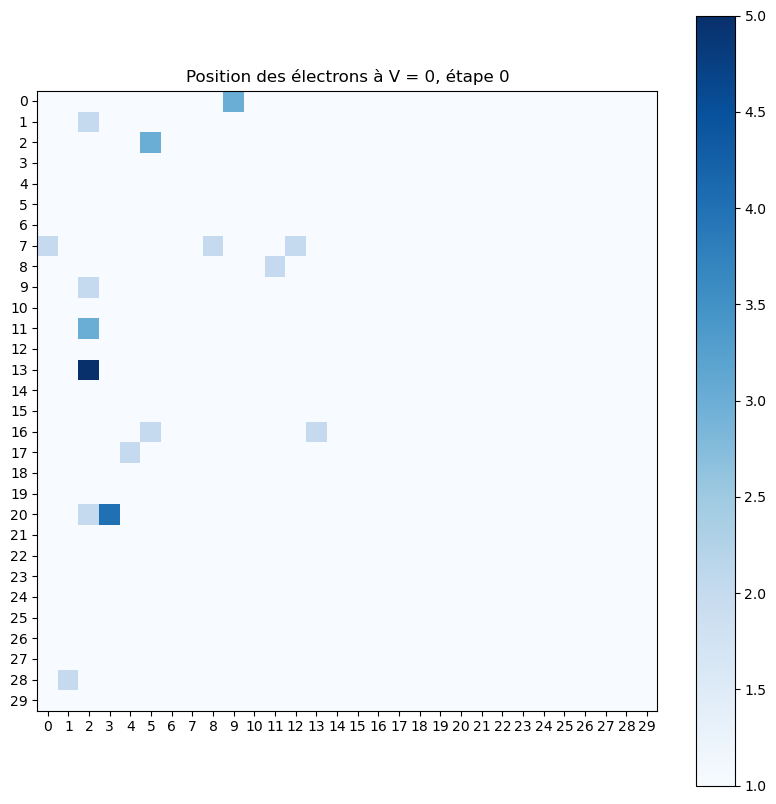

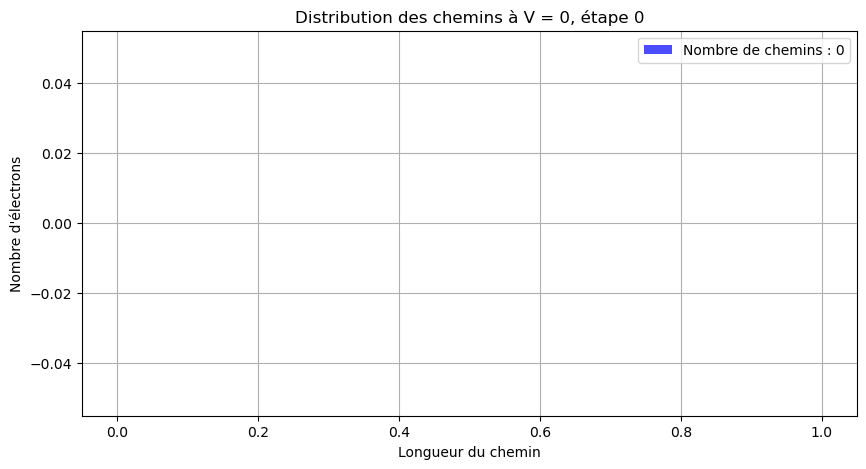

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7240\3073740732.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  res = 1/(np.sum(1/li))
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site

Etape 1, Intensité : 0.0


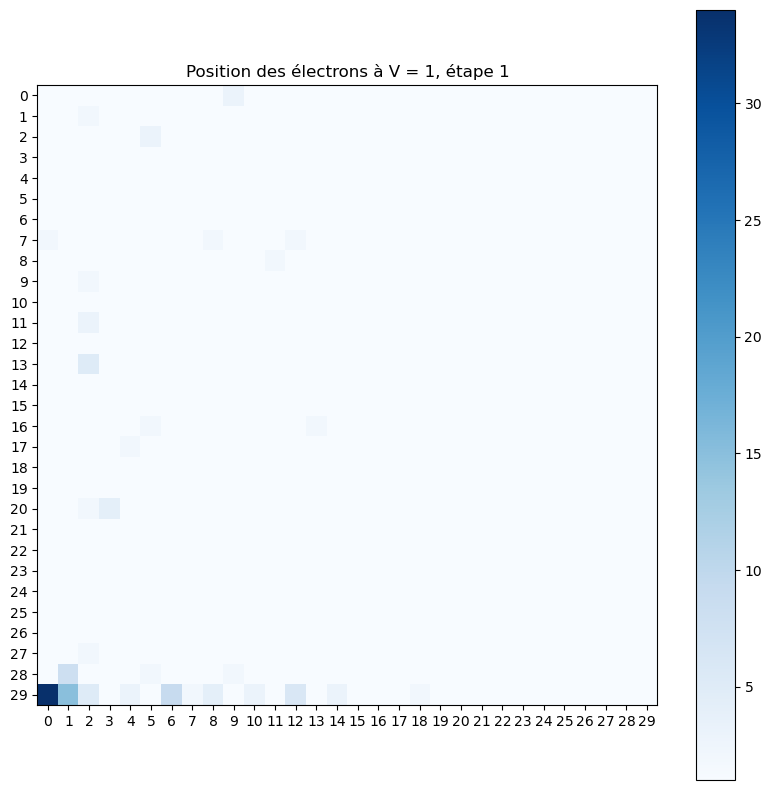

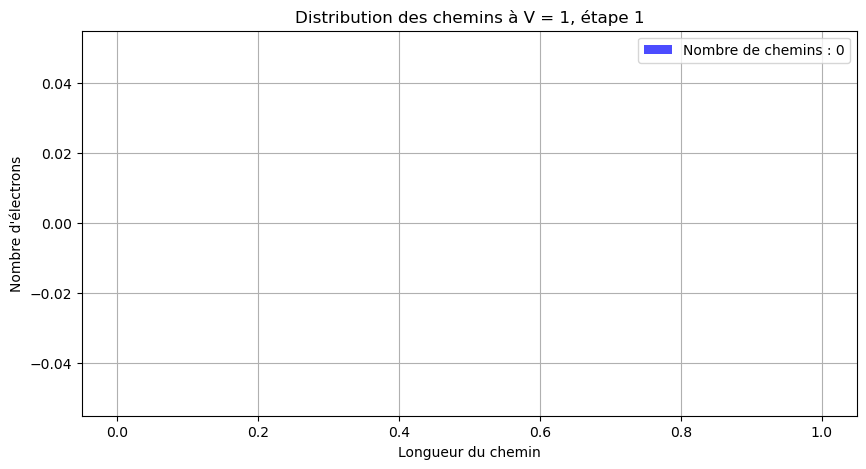

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7240\3073740732.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  res = 1/(np.sum(1/li))
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Log_inst\Programmation-Anaconda\envs\envPSC\Lib\site

Etape 2, Intensité : 0.0


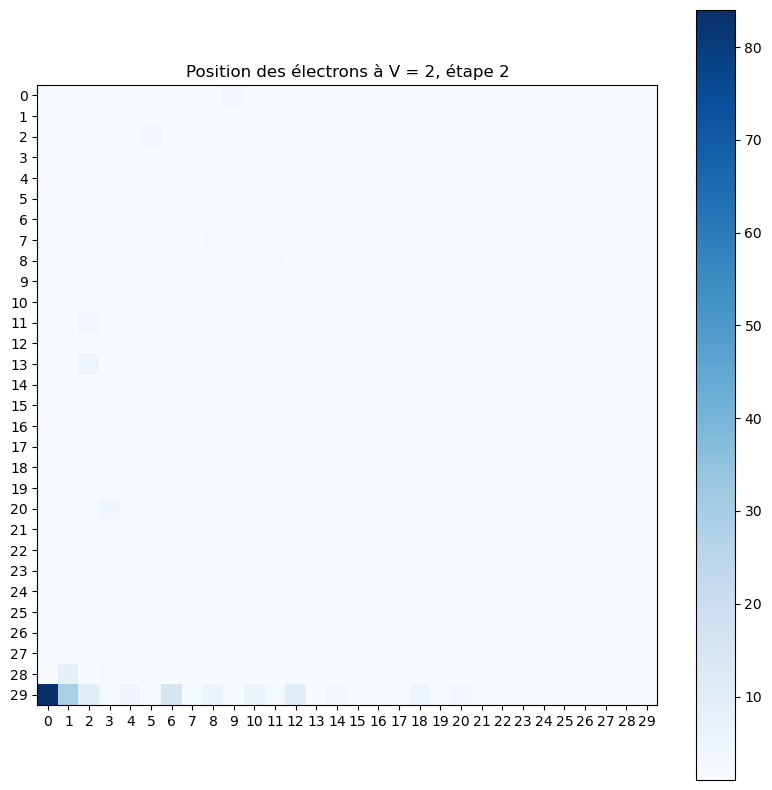

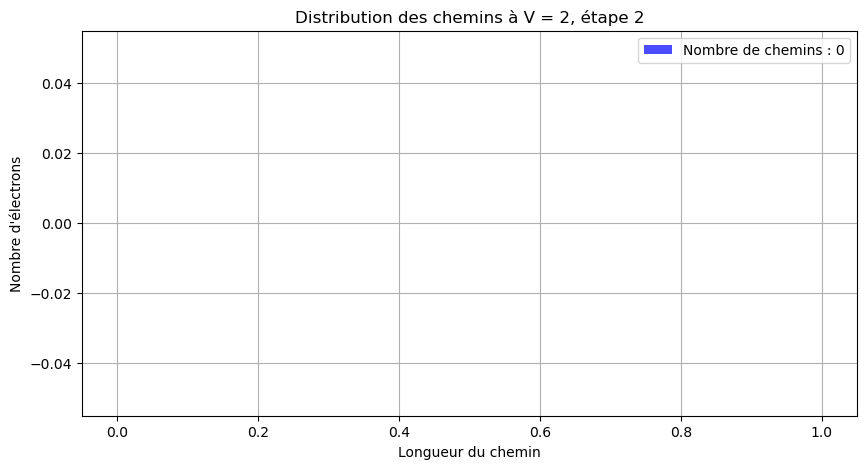

Etape 3, Intensité : 0.006818181818181818


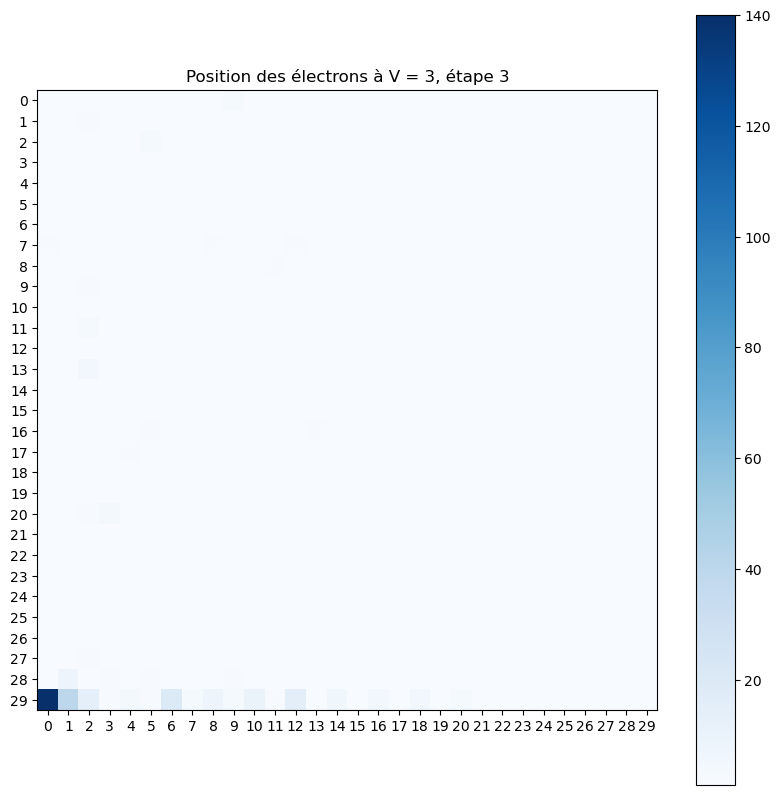

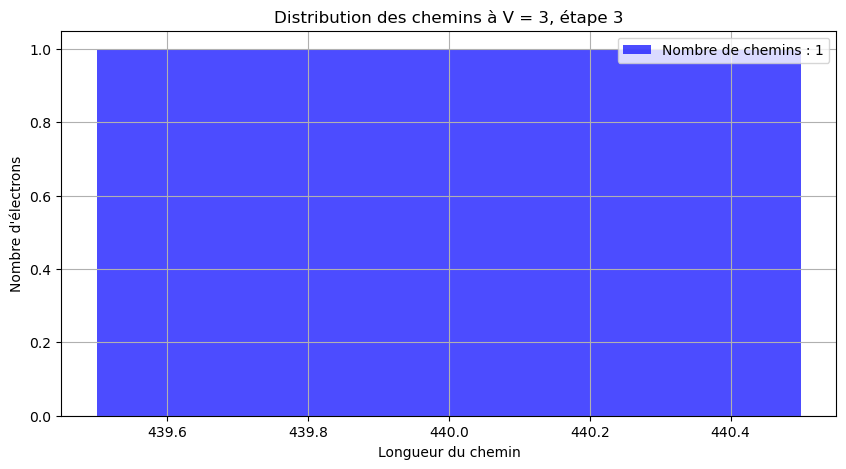

Etape 4, Intensité : 0.17223237939191458


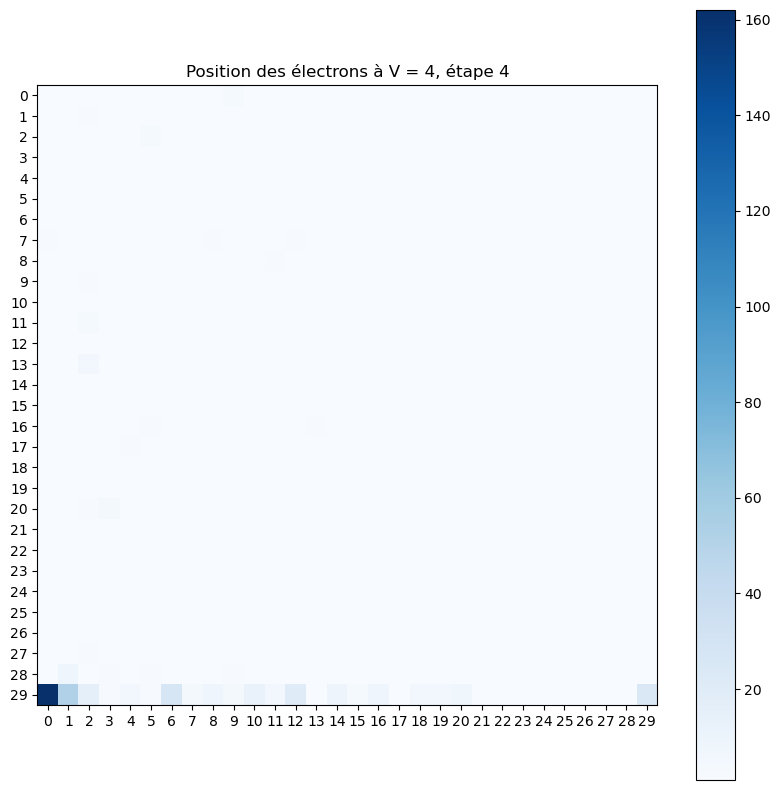

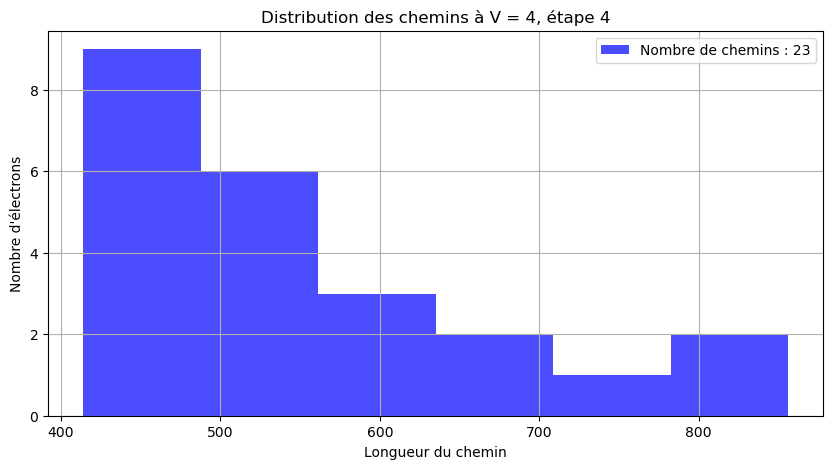

Etape 5, Intensité : 0.20592112661672976


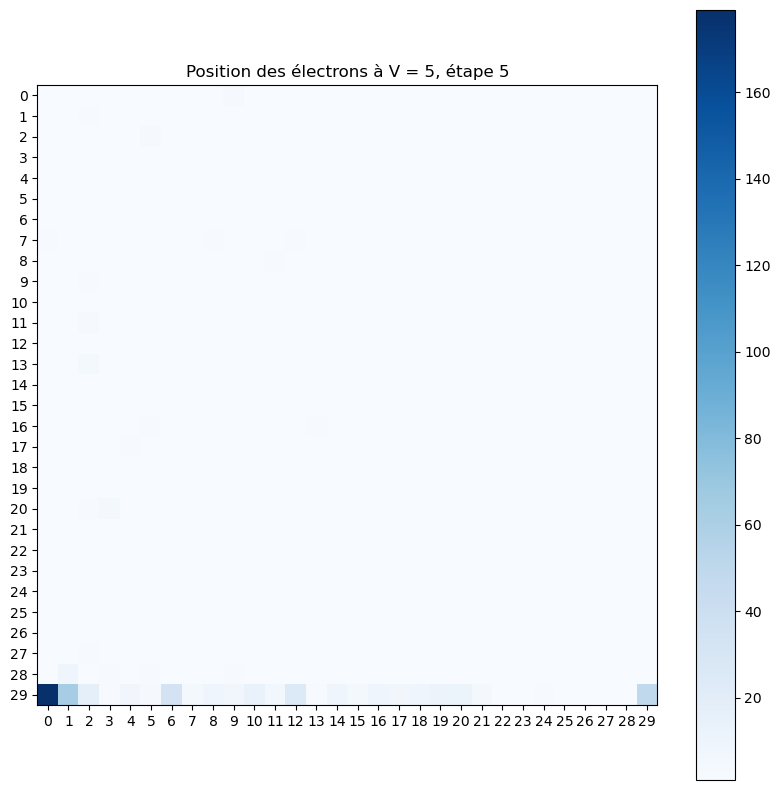

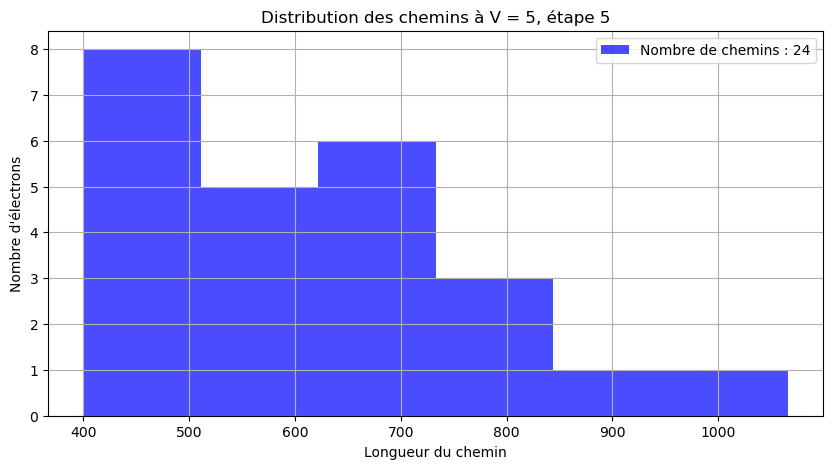

In [ ]:
array_V = list(range(0,10))
array_V += list(range(10,-1,-1))
print(array_V)
simulation(array_V, affiche = True, id = "Test")